<a href="https://colab.research.google.com/github/Heity94/TWSM_Lab/blob/main/TWSM_Lab/Project/Notebooks/TE_WORD2VEC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load DF + preprocessing

This notebook applies a word2vec model to find similar noun phrases.
To evaluate the accuracy of the from the model identified similar noun phrase, we are using the Word Movers Distance.

We choose to use a word2vec model over a doc2vec model, because word2vec has large pre-trained models which can be applied on the data, which doc2vec does not provide. 

The model is applied on one sample article (same article as the other models).

In [23]:
# Declare whether you are on Colab or local
colab = True

In [24]:
if colab==True:
  
  #Mount drive
  from google.colab import drive
  drive.mount('/content/drive')


  #set path to data in Google Drive
  data_path = "/content/drive/MyDrive/Colab Notebooks/TWSM Project/2022_Analytics Lab Student Projects/Data/Topic 1/Data_Team1/"


  #install required packages
  #!pip install duckdb
  #!pip install -U sentence-transformers

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
import pandas as pd
import pickle
import numpy as np

In [26]:
# Load new noun_phrases from sentences.csv data and ontology
if colab==True:
  noun_phrases = pd.read_csv(data_path+"SynDet/SynDet_entities_train.csv")
else:
  noun_phrases = pd.read_csv("../SynDet_entities_train.csv")

if colab==True:
  ontology_syn = pd.read_csv(data_path+"SynDet/SynDet_ontology_train.csv")
else:
  ontology_syn = pd.read_csv("../SynDet_ontology_train.csv")

In [27]:
noun_phrases.head(2)

,Unnamed: 0,article_id,sentence_id,ent_id,noun_phrases,true_ent_id
0,0,188,188_3753_3772,videotex,which,0
1,1,188,188_3753_3772,videotex,we,0


In [28]:
ontology_syn.head(2)

,Unnamed: 0,entity_id,category,label,synonym
0,0,sampling,methodological entity,SAMPLING,sampling
1,0,data analysis method,methodological entity,ANALYSIS_METHOD,data analysis investigation


In [29]:
#convert column to strings from noun_phrases
noun_phrases['noun_phrases'] = noun_phrases['noun_phrases'].astype(str)

# filter df noun_phrases for article 188
noun_phrases = noun_phrases.loc[noun_phrases["article_id"]==188]


In [30]:
#tokenizing the noun_phrases
from nltk.tokenize import RegexpTokenizer

tokenizer_reg = RegexpTokenizer(r'\w+')

noun_phrases["tokens"] = noun_phrases["noun_phrases"].apply(tokenizer_reg.tokenize)
noun_phrases.head()

,Unnamed: 0,article_id,sentence_id,ent_id,noun_phrases,true_ent_id,tokens
0,0,188,188_3753_3772,videotex,which,0,[which]
1,1,188,188_3753_3772,videotex,we,0,[we]
2,2,188,188_3753_3772,videotex,an information,0,"[an, information]"
3,3,188,188_3753_3772,videotex,communication resource,0,"[communication, resource]"
4,4,188,188_3753_3772,videotex,the Minitel system,0,"[the, Minitel, system]"


#### Downsampling the synonyms 

In [31]:
# Check number of synonyms per entity_id
ent_sy_group = ontology_syn.groupby("entity_id")[["synonym"]].nunique().sort_values(by="synonym", ascending=False)

In [32]:
# Downsample entities with more than 100 synonyms to a 100 synoyms (but always include "main entity_id" in subsample)
idx = ent_sy_group[ent_sy_group["synonym"]>100].index.tolist()

dfs = []
for entity in idx:
  t1 = ontology_syn[(ontology_syn.entity_id==entity)&(ontology_syn.synonym==entity)]
  t2 = ontology_syn[(ontology_syn.entity_id==entity)&(ontology_syn.synonym!=entity)].sample(99)
  dfs.append(pd.concat([t1,t2]))
dfs.append(ontology_syn.loc[~ontology_syn["entity_id"].isin(idx)]) # Append dataframe for all entities with less then 100 synonyms to list

# Combine all dataframes 
ontology_syn_ds = pd.concat(dfs).reset_index(drop=True)

In [33]:
#List of unique entities from ontology with synonyms with downsampling
ontology_syn_ds_unique = ontology_syn_ds.drop_duplicates(subset="synonym")
ontology_syn_ds_unique.head()

,Unnamed: 0,entity_id,category,label,synonym
0,4326,individual participant,study object,PARTICIPANTS,individual participant
1,100654,individual participant,study object,PARTICIPANTS,knowledge and multicultural professional consu...
2,151698,individual participant,study object,PARTICIPANTS,professional and security executive expert
3,96117,individual participant,study object,PARTICIPANTS,IT and senior financial physician
4,8744,individual participant,study object,PARTICIPANTS,executive research users ( )


In [34]:
# Create Dictionary noun_phrases
from gensim.corpora import Dictionary
dictionary_noun_phrases=Dictionary(noun_phrases.tokens)
print(dictionary_noun_phrases)

Dictionary(853 unique tokens: ['which', 'we', 'an', 'information', 'communication']...)


In [35]:
#tokenizing the ontology_syn_ds
ontology_syn_ds_unique["tokens"] = ontology_syn_ds_unique.loc[:,"synonym"].apply(tokenizer_reg.tokenize)
ontology_syn_ds_unique.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Unnamed: 0,entity_id,category,label,synonym,tokens
0,4326,individual participant,study object,PARTICIPANTS,individual participant,"[individual, participant]"
1,100654,individual participant,study object,PARTICIPANTS,knowledge and multicultural professional consu...,"[knowledge, and, multicultural, professional, ..."
2,151698,individual participant,study object,PARTICIPANTS,professional and security executive expert,"[professional, and, security, executive, expert]"
3,96117,individual participant,study object,PARTICIPANTS,IT and senior financial physician,"[IT, and, senior, financial, physician]"
4,8744,individual participant,study object,PARTICIPANTS,executive research users ( ),"[executive, research, users]"


## Gensim - Word2Vec 

We chose the pre-trained word2vec model "word2vec-google-news-300", this dataset was trained on about 100 billion words and contains 300-dimensional vectors for 3 million words and phrases.


Choose preferred model import:

In [ ]:
#load model as api
#import gensim.downloader as api
#model = api.load('word2vec-google-news-300')

In [ ]:
#download model
#import gensim.downloader
#word2vec = gensim.downloader.load("word2vec-google-news-300")

In [36]:
#import model from drive
from gensim.models import KeyedVectors
# Load vectors directly from the file
model = KeyedVectors.load_word2vec_format(data_path+"GoogleNews-vectors-negative300.bin.gz", binary=True)

### Word Mover’s Distance (WMD)

Word Movers Distance: distance function between documents

WMD adapts the earth movers distance (EMD) to the space of documents. EMD is as a measure of the distance between two probabilty distributions over a region.

Uses the word embeddings of two documents which are compared and measures the minimum distance that the embedded words in document 1 need to travel in semantic space to reach the embedded words of document 2.

A small distance means that the two documents are close to each other, and therefore similar. 




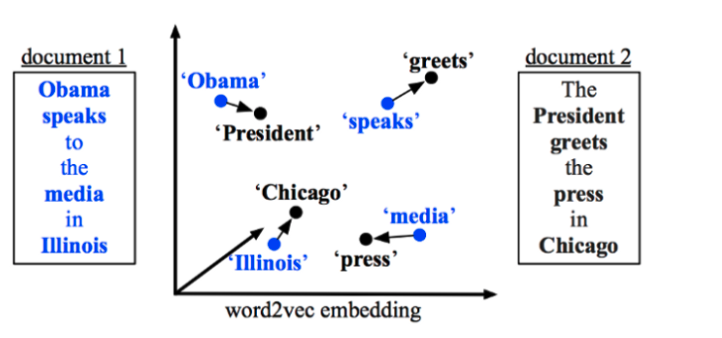

Figure 1: WMD 

Kusner, M., Sun, Y., Kolkin, N. , Weinberger, K.. (2015). From Word Embeddings To Document Distances.

Source: https://mkusner.github.io/publications/WMD.pdf, retrieved: 02.07.2022

In [37]:
#Preparing ontology_syn_ds_unique df for the WMD Similarity method by converting the df to a list of tokens
ontology_syn_ds_unique_list = ontology_syn_ds_unique["synonym"].apply(lambda x:x.split()).to_list()

In [ ]:
#import Word Movers Distance Similarity and apply on the pre-trained word2vec model and the ontology_syn_ds_unique_list
#search only for the best match: num_best = 1
from gensim.similarities import WmdSimilarity
index = WmdSimilarity(ontology_syn_ds_unique_list, model.wv, num_best = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [ ]:
#try the WmdSimilarity on one example in the noun phrase table
query = noun_phrases["tokens"].iloc[10]
sims = index[query]  #look-up in the WmdSimilarity index
print(sims)

[(32304, 0.5970549674148199)]


In [ ]:
#check the match found by the WmdSimilarity
print("noun phrase: "+str(query))
print("matched entity: "+str(ontology_syn_ds_unique_list[32304]))
print("score: "+ str(sims[0][1]))

noun phrase: ['further', 'ampli', 'ed']
matched entity: ['further', 'research']
score: 0.5970549674148199


In [ ]:
#finding the best synonym for noun_phrases (already filtered to: article_id==188) and get the similarity_score (WMD-score)

similarity_score = []
ontology_txt = []

num_best=1
for x in noun_phrases.tokens:
  query = x
  sims = index[x]
  for i in range(num_best):
    try:
      similarity_score.append(sims[i][1])
      ontology_txt.append(ontology_syn_ds_unique_list[sims[i][0]])
    except IndexError:
        similarity_score.append("not in index range")
        ontology_txt.append("not in index range")

In [ ]:
#add to df noun_phrases_scores
noun_phrases_scores = noun_phrases
noun_phrases["similarity_score"] = similarity_score
noun_phrases["ontology_txt"] = ontology_txt

In [ ]:
noun_phrases_scores.head(20)

,Unnamed: 0,Unnamed: 0.1,article_id,sentence_id,ent_id,noun_phrases,true_ent_id,tokens,similarity_score,ontology_txt
0,0,0,188,188_3753_3772,videotex,which,0,[which],0.473273,"[IS/IT, in, healthcares]"
1,1,1,188,188_3753_3772,videotex,we,0,[we],0.56317,"[interorganizational, I]"
2,2,2,188,188_3753_3772,videotex,an information,0,"[an, information]",0.60661,"[medical, information]"
3,3,3,188,188_3753_3772,videotex,communication resource,0,"[communication, resource]",0.628138,"[IS/IT, resource, management]"
4,4,4,188,188_3753_3772,videotex,the Minitel system,0,"[the, Minitel, system]",0.572878,"[system, in, governments]"
5,5,5,188,188_3828_3848,competitive advantage,It,0,[It],0.481062,"[think, alouds]"
6,6,6,188,188_3828_3848,competitive advantage,any rm,0,"[any, rm]",0.487762,"[does, not, have, any, significant, effects]"
7,7,7,188,188_3828_3848,competitive advantage,the eld,0,"[the, eld]",0.587938,"[of, the, papers]"
8,8,8,188,188_3828_3848,competitive advantage,so competitive advantages,0,"[so, competitive, advantages]",0.689987,"[competitive, advantages]"
9,9,9,188,188_3848_3883,government,This,0,[This],0.463592,"[think, alouds]"


In [ ]:
#save df
#noun_phrases_scores.to_csv(data_path+"noun_phrases_scores.csv")  

In [ ]:
noun_phrases_scores.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,article_id,sentence_id,ent_id,noun_phrases,true_ent_id,tokens,similarity_score,ontology_txt
0,0,0,0,0,188,188_3753_3772,videotex,which,0,['which'],0.4732733882113142,"['IS/IT', 'in', 'healthcares']"
1,1,1,1,1,188,188_3753_3772,videotex,we,0,['we'],0.5631700901822527,"['interorganizational', 'I']"
2,2,2,2,2,188,188_3753_3772,videotex,an information,0,"['an', 'information']",0.6066101391194407,"['medical', 'information']"
3,3,3,3,3,188,188_3753_3772,videotex,communication resource,0,"['communication', 'resource']",0.6281378354394097,"['IS/IT', 'resource', 'management']"
4,4,4,4,4,188,188_3753_3772,videotex,the Minitel system,0,"['the', 'Minitel', 'system']",0.5728775449540222,"['system', 'in', 'governments']"


In [ ]:
#cleaning the column "ontology_txt"

In [ ]:
noun_phrases_scores["ontology_txt"] = noun_phrases_scores["ontology_txt"].str.replace(",", "")

In [ ]:
noun_phrases_scores["ontology_txt"] = noun_phrases_scores["ontology_txt"].str.replace("'", "")

In [ ]:
noun_phrases_scores["ontology_txt"] = noun_phrases_scores["ontology_txt"].str.replace("[", "")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


In [ ]:
noun_phrases_scores["ontology_txt"] = noun_phrases_scores["ontology_txt"].str.replace("]", "")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


In [ ]:
noun_phrases_scores.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,article_id,sentence_id,ent_id,noun_phrases,true_ent_id,tokens,similarity_score,ontology_txt
0,0,0,0,0,188,188_3753_3772,videotex,which,0,['which'],0.4732733882113142,IS/IT in healthcares
1,1,1,1,1,188,188_3753_3772,videotex,we,0,['we'],0.5631700901822527,interorganizational I
2,2,2,2,2,188,188_3753_3772,videotex,an information,0,"['an', 'information']",0.6066101391194407,medical information
3,3,3,3,3,188,188_3753_3772,videotex,communication resource,0,"['communication', 'resource']",0.6281378354394097,IS/IT resource management
4,4,4,4,4,188,188_3753_3772,videotex,the Minitel system,0,"['the', 'Minitel', 'system']",0.5728775449540222,system in governments


In [ ]:
#drop not required columns
noun_phrases_clean = noun_phrases_scores.drop(columns=["article_id", "Unnamed: 0.1", "Unnamed: 0", "Unnamed: 0.1.1", "Unnamed: 0.1.1.1", "tokens", "true_ent_id"])
noun_phrases_clean

,sentence_id,ent_id,noun_phrases,similarity_score,ontology_txt
0,188_3753_3772,videotex,which,0.4732733882113142,IS/IT in healthcares
1,188_3753_3772,videotex,we,0.5631700901822527,interorganizational I
2,188_3753_3772,videotex,an information,0.6066101391194407,medical information
3,188_3753_3772,videotex,communication resource,0.6281378354394097,IS/IT resource management
4,188_3753_3772,videotex,the Minitel system,0.5728775449540222,system in governments
...,...,...,...,...,...
3222,188_3675_3704,government,mind,0.49290139466647426,thinking alouds
3223,188_3704_3727,government,the French people,0.5347515368856867,statistic the hypothesis
3224,188_3704_3727,government,the government,0.6226555134885214,government I
3225,188_3704_3727,government,the French superhighway,0.529844106122733,theory of the commons


In [41]:
#save clean df
#noun_phrases_clean.to_csv(data_path+"wmd_syn_clean.csv")  
#noun_phrases_clean = pd.read_csv(data_path+"wmd_syn_clean.csv", index_col=0)

In [45]:
noun_phrases_clean = noun_phrases_clean.rename(columns={"ontology_txt": "closest_entity"})
noun_phrases_clean

,sentence_id,ent_id,noun_phrases,similarity_score,closest_entity
0,188_3753_3772,videotex,which,0.4732733882113142,IS/IT in healthcares
1,188_3753_3772,videotex,we,0.5631700901822527,interorganizational I
2,188_3753_3772,videotex,an information,0.6066101391194407,medical information
3,188_3753_3772,videotex,communication resource,0.6281378354394097,IS/IT resource management
4,188_3753_3772,videotex,the Minitel system,0.5728775449540222,system in governments
...,...,...,...,...,...
3222,188_3675_3704,government,mind,0.49290139466647426,thinking alouds
3223,188_3704_3727,government,the French people,0.5347515368856867,statistic the hypothesis
3224,188_3704_3727,government,the government,0.6226555134885214,government I
3225,188_3704_3727,government,the French superhighway,0.529844106122733,theory of the commons


In [46]:
#merge dfs to get main_entity_id
noun_phrases_mapped = noun_phrases_clean.merge(ontology_syn_ds_unique, 
                                               how="left", left_on="closest_entity", right_on="synonym").drop(columns=["category", "label", "synonym", "ent_id"])

In [47]:
noun_phrases_mapped.head()

,sentence_id,noun_phrases,similarity_score,closest_entity,Unnamed: 0,entity_id,tokens
0,188_3753_3772,which,0.4732733882113142,IS/IT in healthcares,14171.0,health information system,"[IS, IT, in, healthcares]"
1,188_3753_3772,we,0.5631700901822527,interorganizational I,2895.0,interorganizational system,"[interorganizational, I]"
2,188_3753_3772,an information,0.6066101391194407,medical information,14450.0,healthcare data,"[medical, information]"
3,188_3753_3772,communication resource,0.6281378354394097,IS/IT resource management,14001.0,IT resource management,"[IS, IT, resource, management]"
4,188_3753_3772,the Minitel system,0.5728775449540222,system in governments,13889.0,government system,"[system, in, governments]"


In [51]:
#drop not required columns and rename columns
noun_phrases_mapped = noun_phrases_mapped.drop(columns=["Unnamed: 0", "tokens"]).rename(columns={"entity_id": "main_entity_id"})

In [52]:
noun_phrases_mapped.head()

,sentence_id,noun_phrases,similarity_score,closest_entity,main_entity_id
0,188_3753_3772,which,0.4732733882113142,IS/IT in healthcares,health information system
1,188_3753_3772,we,0.5631700901822527,interorganizational I,interorganizational system
2,188_3753_3772,an information,0.6066101391194407,medical information,healthcare data
3,188_3753_3772,communication resource,0.6281378354394097,IS/IT resource management,IT resource management
4,188_3753_3772,the Minitel system,0.5728775449540222,system in governments,government system


In [53]:
noun_phrases_sample = noun_phrases.loc[noun_phrases["article_id"]==188]

In [54]:
# Merge sim scores on entities sample to get "true" entity id
noun_phrases_mapped_1 = noun_phrases_mapped.merge(noun_phrases_sample
                          [["sentence_id", "noun_phrases", "true_ent_id"]],
                          how="left", on=["sentence_id", "noun_phrases"])

In [55]:
# Define columns which should be checked for duplicates
col_dupl = ['sentence_id', 'noun_phrases', 'closest_entity', 'main_entity_id', 'true_ent_id']

#Drop duplicates
noun_phrases_mapped_1 = noun_phrases_mapped_1.drop_duplicates(subset=col_dupl)

In [56]:
noun_phrases_mapped_1.head(3)


,sentence_id,noun_phrases,similarity_score,closest_entity,main_entity_id,true_ent_id
0,188_3753_3772,which,0.4732733882113142,IS/IT in healthcares,health information system,0
1,188_3753_3772,we,0.5631700901822527,interorganizational I,interorganizational system,0
2,188_3753_3772,an information,0.6066101391194407,medical information,healthcare data,0


In [57]:
#Merge sim scores again on entities sample to get "true" entity id, but this time with the true entity id which was found by Roland
noun_phrases_mapped_f =noun_phrases_mapped_1.merge(noun_phrases_sample[["sentence_id", "ent_id"]], 
                                                           how="left", left_on=["sentence_id", "main_entity_id"], 
                                                           right_on=["sentence_id", "ent_id"])\
                                                           .rename(columns={"ent_id":"true_ent_id_cmpl_sen"})\
                                                           .drop_duplicates()

In [58]:
noun_phrases_mapped_f.head()

,sentence_id,noun_phrases,similarity_score,closest_entity,main_entity_id,true_ent_id,true_ent_id_cmpl_sen
0,188_3753_3772,which,0.4732733882113142,IS/IT in healthcares,health information system,0,NaN
1,188_3753_3772,we,0.5631700901822527,interorganizational I,interorganizational system,0,NaN
2,188_3753_3772,an information,0.6066101391194407,medical information,healthcare data,0,NaN
3,188_3753_3772,communication resource,0.6281378354394097,IS/IT resource management,IT resource management,0,NaN
4,188_3753_3772,the Minitel system,0.5728775449540222,system in governments,government system,0,NaN


In [59]:
# Define function to combine both columns "true_ent_id" & "true_ent_id_cmpl_sen"
def true_ent_label(x):

  if x.true_ent_id!="0":
    return x.true_ent_id
  else:
    return x.true_ent_id_cmpl_sen

In [60]:
# Compare both columns and store correct value  in column true_entity_id
noun_phrases_mapped_f["true_entity_id"] = noun_phrases_mapped_f.apply(lambda x: true_ent_label(x), 
                                                                                axis=1, result_type="expand")

#Fill all NaN Values with 0 (no match)
noun_phrases_mapped_f["true_entity_id"] = noun_phrases_mapped_f["true_entity_id"].fillna(0)

#Drop columns "true_ent_id" & "true_ent_id_cmpl_sen"
noun_phrases_mapped_f = noun_phrases_mapped_f.drop(columns=["true_ent_id", "true_ent_id_cmpl_sen"])

In [61]:
noun_phrases_mapped_f.tail(3)


,sentence_id,noun_phrases,similarity_score,closest_entity,main_entity_id,true_entity_id
4086,188_3704_3727,the government,0.6226555134885214,government I,government system,0
4087,188_3704_3727,the French superhighway,0.529844106122733,theory of the commons,theory of the commons,0
4088,188_3727_3737,The Minitel terminal,0.5364154021729209,operator interface terminal,user interface,0


In [62]:
# Check wheter main_entity based on score is identical to "true" main entity label 
noun_phrases_mapped_f["correct_match"] = noun_phrases_mapped_f.main_entity_id==noun_phrases_mapped_f.true_entity_id

In [ ]:
#Check results for one sample sentence
noun_phrases_mapped_f[(noun_phrases_mapped_f.sentence_id=="188_5984_6028")].sort_values(by="similarity_score", ascending=False)#&(sim_scores_samp

,score,sentence_id,entity_id,noun_phrase_txt,main_entity_id,true_entity_id,correct_match
1204,1.0,188_5984_6028,information superhighway,information infrastructure,information technology infrastructure,information technology infrastructure,True
1255,1.0,188_5984_6028,private sector,information infrastructure,information technology infrastructure,information technology infrastructure,True
1306,1.0,188_5984_6028,hardware,information infrastructure,information technology infrastructure,information technology infrastructure,True
1317,1.0,188_5984_6028,hardware,application,IT workforce,0,False
1215,1.0,188_5984_6028,information superhighway,application,IT workforce,0,False
1266,1.0,188_5984_6028,private sector,application,IT workforce,0,False
1357,1.0,188_5984_6028,information technology infrastructure,information infrastructure,information technology infrastructure,information technology infrastructure,True
1368,1.0,188_5984_6028,information technology infrastructure,application,IT workforce,0,False
1318,0.6956238842940197,188_5984_6028,hardware,service development,information services development,0,False
1216,0.6956238842940197,188_5984_6028,information superhighway,service development,information services development,0,False


In [63]:
#remove the values where loop did not get an index ("not in index range")
noun_phrases_mapped_f = noun_phrases_mapped_f[~noun_phrases_mapped_f.similarity_score.str.contains("not in index range")]

In [64]:
#convert str to float
noun_phrases_mapped_f["similarity_score"] = noun_phrases_mapped_f["similarity_score"].astype(float)

In [67]:
# Create bins of similarity score to check the number of correct matches compared to the labels of the database
grouped_df = noun_phrases_mapped_f.groupby(pd.cut(noun_phrases_mapped_f.similarity_score, np.arange(0.,1.1,0.1)))[["correct_match"]]
corr_match_bins = np.round(grouped_df.sum()/grouped_df.count(),2).rename(columns={"correct_match":"pct_correct_in_bin"})
corr_match_bins["no_correct"]= grouped_df.sum()
corr_match_bins["total"]= grouped_df.count()
corr_match_bins = corr_match_bins[["total", "no_correct", "pct_correct_in_bin"]]
corr_match_bins = corr_match_bins.iloc[::-1] #reverse order

In [68]:
corr_match_bins

,total,no_correct,pct_correct_in_bin
similarity_score,,,
"(0.9, 1.0]",128,23,0.18
"(0.8, 0.9]",0,0,NaN
"(0.7, 0.8]",70,21,0.30
"(0.6, 0.7]",494,102,0.21
"(0.5, 0.6]",521,29,0.06
"(0.4, 0.5]",299,5,0.02
"(0.3, 0.4]",0,0,NaN
"(0.2, 0.3]",0,0,NaN
"(0.1, 0.2]",0,0,NaN


As we can see, the WMD Algorithm does not perform very will in finding the correct match (also compared to the other models) 
The performance could have been improved by removing stop words and applying different pre-trained models, as suggested by the authors in the whitepaper of WMD. But as the performance of Sentence Bert was extremely better and our time limited, we decided not to pursue that approach. 

(Kusner, M., Sun, Y., Kolkin, N. , Weinberger, K.. (2015). From Word Embeddings To Document Distances.)

In [ ]:
#pre pro - remove stop words
#define WMD Score (what is it exactly - compareable to CS?)